# Lab 08: Categorical Variable Relationships

This lab is presented with some revisions from [Dennis Sun at Cal Poly](https://web.calpoly.edu/~dsun09/index.html) and his [Data301 Course](http://users.csc.calpoly.edu/~dsun09/data301/lectures.html)

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)

So far, we have seen different ways to summarize and visualize _individual_ variables in a data set. But we have not really discussed how to summarize and visualize relationships between _multiple_ variables. This chapter is all about how to understand relationships between the columns in a `DataFrame`. The methods will be different, depending on whether the variables are categorical or quantitative.

In this section, we look at ways to summarize the relationship between two _categorical_ variables. To do this, we will again use the Titanic data set.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

titanic_df = pd.read_csv("./data/titanic.csv")
titanic_df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


Suppose we want to understand the relationship between where a passenger embarked and what class they were in. We can completely summarize this relationship by counting the number of passengers in each class that embarked at each location. We can create a pivot table that summarizes this information.

In [2]:
embarked_pclass_counts = titanic_df.pivot_table(
    index="embarked", columns="pclass",
    values="name",  # We can pretty much count any column, as long as there are no NaNs.
    aggfunc="count" # The count function will count the number of non-null values.
)
embarked_pclass_counts

pclass,1,2,3
embarked,,,
C,141,28,101
Q,3,7,113
S,177,242,495


Recall that the field embarked is coded categorically using: `embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)`

A pivot table that stores counts is also called a **contigency table** or a **cross-tabulation**. This type of pivot table is common enough that there is a specific function in `pandas` to calculate one, allowing you to bypass `.pivot_table`:

In [3]:
counts = pd.crosstab(titanic_df.embarked, titanic_df.pclass)
counts

pclass,1,2,3
embarked,,,
C,141,28,101
Q,3,7,113
S,177,242,495


## Joint Distributions

It is common to normalize the counts in a table so that they add up to 1. These proportions represent the **joint distribution** of the two variables.

To calculate the joint distribution, we need to divide the table of counts above by the total count. To find the total count, we call `.sum()` twice; the first call gives us the sum of each column, and the second call adds those numbers together.

In [4]:
print(counts.sum().sum())
joint = counts / counts.sum().sum()
joint

1307


pclass,1,2,3
embarked,,,
C,0.107881,0.021423,0.077276
Q,0.002295,0.005356,0.086458
S,0.135425,0.185157,0.378730


Note that this is yet another example of broadcasting. When we divided the `DataFrame` `counts` by the number 1307, the division was applied elementwise, producing another `DataFrame`.

Each cell in this `DataFrame` tells us a joint proportion. For example, the cell in the bottom right tells us the proportion of all passengers that embarked at Southampton and were in 3rd class. We notate this joint proportion as follows:

$$ P(\text{embarked at Southampton and in 3rd class}) = .379. $$

The joint distribution above could also have been obtained by specifying `normalize=True` when the contingency table was first created:

In [5]:
pd.crosstab(titanic_df.embarked, titanic_df.pclass,
            normalize=True)

pclass,1,2,3
embarked,,,
C,0.107881,0.021423,0.077276
Q,0.002295,0.005356,0.086458
S,0.135425,0.185157,0.378730


The above joint distribution is not, strictly speaking, a contingency table. A contingency table is a table of all counts, while the above table is a table of proportions.

## Marginal Distributions

The **marginal distribution** of a variable is simply the distribution of that variable, ignoring the other variables. To calculate the marginal distribution from a joint distribution of two variables, we sum the rows or the columns of the joint distribution.

For example, to calculate the marginal distribution of `embarked`, we have to sum the joint distribution over the columns---in other words, _roll-up_ or _marginalize over_ the `pclass` variable:

In [6]:
joint.sum(axis=1)

embarked
C    0.206580
Q    0.094109
S    0.699311
dtype: float64

We can check this answer by calculating the distribution of `embarked` directly from the original data, ignoring `pclass` entirely.

In [7]:
embarked_counts = titanic_df.groupby("embarked")["name"].count()
embarked_counts / embarked_counts.sum()

embarked
C    0.206580
Q    0.094109
S    0.699311
Name: name, dtype: float64

The numbers match!

Likewise, we calculate the marginal distribution of `pclass` by summing the joint distribution over the rows---in other words, by _rolling-up_ or _marginalizing over_ the `embarked` variable:

In [8]:
joint.sum(axis=0)

pclass
1    0.245601
2    0.211936
3    0.542464
dtype: float64

So given the joint distribution of two categorical variables, there are two marginal distributions: one for each of the variables. These marginal distributions are obtained by summing the joint distribution table over the rows and over the columns.

The _marginal distribution_ is so-named because these row and column totals would typically be included alongside the joint distribution, in the _margins_ of the table. A contingency table with the marginal distributions included can be obtained by specifying `margins=True` in `pd.crosstab`:

In [9]:
pd.crosstab(titanic_df.embarked, titanic_df.pclass,
            normalize=True, margins=True)

pclass,1,2,3,All
embarked,,,,
C,0.107881,0.021423,0.077276,0.206580
Q,0.002295,0.005356,0.086458,0.094109
S,0.135425,0.185157,0.378730,0.699311
All,0.245601,0.211936,0.542464,1.000000


Notice in the above that the sum over all elements of the join distribution (the bottom right corner) is a probability distribution (sums to 1.0).  Likewise the sum over either of the computed marginal distributions is also a probability distribution (sums to 1.0).

## Conditional Distributions

The **conditional distribution** tells us about the distribution of one variable, _conditional on_ the value of another. For example, we might want to know the proportion of 3rd class passengers that embarked at each location. In other words, what is the distribution of where a passenger embarked, _conditional on_ being in 3rd class?

If we go back to the contingency table:

In [10]:
embarked_pclass_counts

pclass,1,2,3
embarked,,,
C,141,28,101
Q,3,7,113
S,177,242,495


there were $101 + 113 + 495 = 709$ passengers in 3rd class, of whom 

- $101 / 709 = .142$ were in 1st class,
- $113 / 709 = .159$ were in 2nd class, and
- $495 / 709 = .698$ were in 3rd class.

We can calculate these proportions in code by dividing the `pclass=3` column by its sum:

In [11]:
embarked_pclass_counts[3] / embarked_pclass_counts[3].sum()

embarked
C    0.142454
Q    0.159379
S    0.698166
Name: 3, dtype: float64

Notice that these three proportions add up to 1, making this a proper distribution.

This conditional distribution helps us answer questions such as, "What proportion of 3rd class passengers embarked at Southampton?" We notate this conditional proportion as follows:

$$ P\big(\textrm{embarked at Southampton}\ \big|\ \textrm{in 3rd class}\big) = 0.698. $$

The pipe $\big|$ is read "given". So we are interested in the proportion of passengers who embarked at Southampton, _given_ that they were in 3rd class.

We could have also calculated this conditional distribution from the joint distribution (i.e., proportions instead of counts):

In [12]:
joint[3] / joint[3].sum()

embarked
C    0.142454
Q    0.159379
S    0.698166
Name: 3, dtype: float64

We have just calculated _one_ of the conditional distributions of `embarked`: the distribution conditional on being in 3rd class. There are two more conditional distributions of `embarked`: 

- the distribution conditional on being in 1st class 
- the distribution conditional on being in 2nd class

It is common to report _all_ of the conditional distributions of one variable given another variable.

Of course, it is straightforward to calculate these conditional distributions manually:

In [13]:
embarked_pclass_counts[1] / embarked_pclass_counts[1].sum()

embarked
C    0.439252
Q    0.009346
S    0.551402
Name: 1, dtype: float64

In [14]:
embarked_pclass_counts[2] / embarked_pclass_counts[2].sum()

embarked
C    0.101083
Q    0.025271
S    0.873646
Name: 2, dtype: float64

But there is a nifty trick for calculating all three conditional distributions at once. By summing the counts over `embarked`, we obtain the total number of people in each `pclass`:

In [15]:
pclass_counts = embarked_pclass_counts.sum(axis=0)
pclass_counts

pclass
1    321
2    277
3    709
dtype: int64

This is exactly what we need to divide each column of `embarked_pclass_counts` by:

In [16]:
embarked_given_pclass = embarked_pclass_counts.divide(pclass_counts, axis=1)
embarked_given_pclass

pclass,1,2,3
embarked,,,
C,0.439252,0.101083,0.142454
Q,0.009346,0.025271,0.159379
S,0.551402,0.873646,0.698166


(This is yet another example of _broadcasting_, since we are dividing a `DataFrame` by a `Series`.)

Compare each column with the numbers we obtained earlier. Notice also that each column sums to 1, a reminder that each column represents a separate distribution.

When comparing numbers across distributions, it is important to be careful. For example, the 87.4% and the 69.8% in the "Southampton" row represent **percentages of different populations that have different sizes!**. Just because 87.4% is higher than 69.8% does not mean that more 2nd class passengers boarded at Southampton than 3rd class passengers. In fact, if we go back to the original contingency table, we see that more 3rd class passengers actually boarded at Southampton than 2nd class passengers!

There is also another set of conditional distributions for these two variables: the distribution of class, conditional on where they embarked. To calculate these conditional distributions, we instead divide `embarked_pclass_counts` by the sum of each row:

In [17]:
embarked_counts = embarked_pclass_counts.sum(axis=1)
pclass_given_embarked = embarked_pclass_counts.divide(embarked_counts, axis=0)
pclass_given_embarked

pclass,1,2,3
embarked,,,
C,0.522222,0.103704,0.374074
Q,0.024390,0.056911,0.918699
S,0.193654,0.264770,0.541575


These conditional distributions answer questions like, "What proportion of Southampton passengers were in 3rd class?" 

Notice that these proportions are _not_ the same as the proportions for the other set of conditional distributions. That is because the two questions below are fundamentally different:

_Question 1._ What proportion of 3rd class passengers embarked at Southampton?

$$P\big(\textrm{embarked at Southampton}\ \big|\ \textrm{in 3rd class}\big) = \frac{\text{# passengers who embarked at Southampton and in 3rd class}}{\text{# passengers who in 3rd class}}$$

_Question 2._ What proportion of Southampton passengers were in 3rd class? 

$$P\big(\textrm{in 3rd class}\ \big|\ \textrm{embarked at Southampton}\big) = \frac{\text{# passengers who embarked at Southampton and in 3rd class}}{\text{# passengers who embarked at Southampton}} \\ $$



In the first case, the reference population is all passengers who embarked at Southampton. In the second case, the reference population is all passengers who were in 3rd class. The numerators may be the same, but the denominators are different. In general, the conditional distributions of $X$ given $Y$ are _not_ the same as the conditional distributions of $Y$ given $X$. 

If we rephrase the question slightly, we get yet another answer:

_Question 3._ What proportion of passengers embarked at Southampton _and_ were in 3rd class?

$$P(\text{embarked at Southampton and in 3rd class}) = \frac{\text{# passengers who embarked at Southampton and in 3rd class}}{\text{# passengers (total)}}$$

The reference population here is all passengers. This is the proportion that one would get from the joint distribution.

It is important to pay attention to the wording of the question, to determine whether a joint distribution or a conditional distribution is called for---and, if the latter, which of the two conditional distributions is appropriate.

## Visualization

How do we visualize the joint and conditional distributions of two categorical variables? (Marginal distributions are summaries of a single variable and can be visualized using the techniques of Chapter 1.)

To visualize a joint distribution, we need to be able to represent three dimensions: two dimensions for the two categorical variables and a third dimension for the proportions. Although one option is a 3D graph, humans are not good at judging the sizes of 3D objects printed on a page. For this reason, **heat maps**, which use a color scale to represent the third dimension, are usually preferred. 

Unfortunately, heat maps are still not easy to create in `pandas`. We use the `seaborn` library to make a heat map:

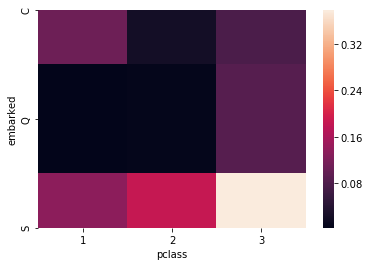

In [18]:
import seaborn as sns

sns.heatmap(joint)

A heat map encourages comparison across cells. So we see that 3rd class passengers who embarked at Southampton were by far the most common.

Although a heat map can also be used to visualize conditional distributions, it is not ideal because it does not tell us which variable we are conditioning on, and it is difficult to judge visually which dimension sums to 1. A stacked bar graph is better because it visually shows values summing to 1.

To make a stacked bar graph, we simply specify `stacked=True` in `.plot.bar()`, to get the bars to show up on top of one another, instead of side-by-side:

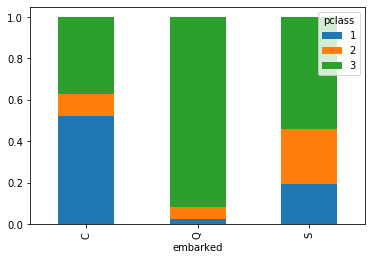

In [19]:
pclass_given_embarked.plot.bar(stacked=True)

However, the same code does not work on the other set of conditional distributions:

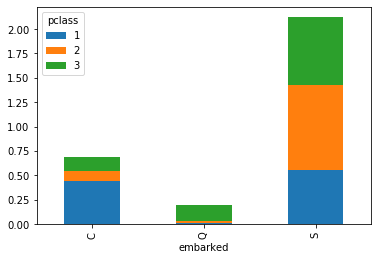

In [21]:
embarked_given_pclass.plot.bar(stacked=True)

What went wrong? Recall that `.plot.bar()` automatically plots the (row) index of the `DataFrame` on the $x$-axis. To plot the distribution of `embarked` conditional on `pclass`, we need `pclass` to be on the $x$-axis, but 

In [22]:
embarked_given_pclass

pclass,1,2,3
embarked,,,
C,0.439252,0.101083,0.142454
Q,0.009346,0.025271,0.159379
S,0.551402,0.873646,0.698166


has `embarked` as the index. To make `pclass` the index, we can **transpose** this `DataFrame` so that the rows become columns and the columns become rows. The syntax for transposing a `DataFrame` is `.T`, which is inspired by the notation for transposing a matrix in linear algebra.

In [23]:
embarked_given_pclass.T

embarked,C,Q,S
pclass,,,
1,0.439252,0.009346,0.551402
2,0.101083,0.025271,0.873646
3,0.142454,0.159379,0.698166


Now, we can make a stacked bar graph from this _transposed_ `DataFrame`:

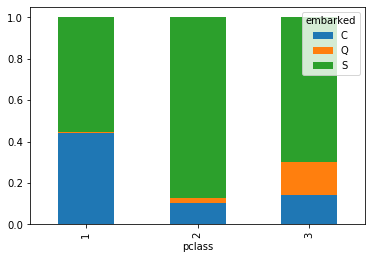

In [24]:
(embarked_given_pclass.T).plot.bar(stacked=True)

## Summing Up About Conditionals Probabilities

We have discussed three different types of distributions (probabilities).  Remember that for two events $X$ and $Y$:

* Joint Distribution:  The probabilitiy of two events occuring at the same time.  Formally: $P(X \cap Y)$.  We typically use heatmaps to show joint distributions.
* Marginal Distribution: The probabilitiy of a single event, irrespective of any other event (i.e., marginalizing the other event).  Formally: $P(X)$.  We can use the graphs learned before (pie charts, bar graphs) to visualize these.
* Conditional Distribution:  The probability of an event $X$ happening given that some event $Y$ has also happened.  Formally: $P(X|Y) = \frac{P(X \cap Y)}{P(Y)}$.  We typically use stacked bar graphs to visualize these distributions.

When comparing across variables it is important to think about the relationship you want to present so that you can clearly and precisely discuss the relationship using the concepts from this notebook.

##  Independence

We would like to measure the strength of the relationship between two variables. _Independence_ is a way to quantify the intuitive notion that two variables are _unrelated_. Once we have defined independence, we can quantify the relationship between two variables by calculating how far they are from independence.

Formally, two variables $X$ and $Y$ are **independent** if the conditional distributions of $Y$ given $X$ (or vice versa) are all _identical_. In other words, the value of $X$ does not affect the distribution of $Y$.

In [26]:
titanic_df["adult"] = (titanic_df["age"] >= 18)

For example, consider the relationship between sex and age group (adult or not). First, let's calculate the contingency table:

In [27]:
counts = pd.crosstab(titanic_df.sex, titanic_df.adult)
counts

adult,False,True
sex,,
female,150,316
male,267,576


Although there are more male adults (576) than female adults (316), the _conditional proportion_ of adults, given sex, are actually very close (about $0.68$).

adult,False,True
sex,,
female,0.321888,0.678112
male,0.316726,0.683274


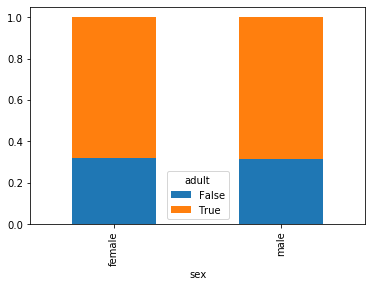

In [28]:
adult_given_sex = counts.divide(counts.sum(axis=1), axis=0)
adult_given_sex.plot.bar(stacked=True)
adult_given_sex 

Because the conditional distribution of `adult` is (approximately) the same, regardless of whether we are conditioning on `sex` = male or `sex` = female, we say that the two variables are (approximately) independent. 

For an example of two non-independent variables, consider passenger class and age group. If we look at the conditional distributions of `adult` given `pclass`, they are not all the same:

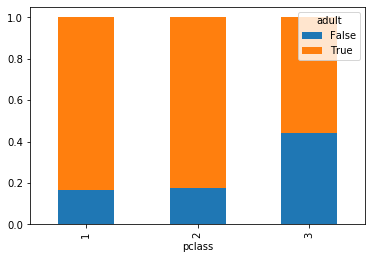

In [29]:
adult_pclass_counts = pd.crosstab(titanic_df.pclass, titanic_df.adult)
(adult_pclass_counts.divide(
    adult_pclass_counts.sum(axis=1), axis=0)
).plot.bar(stacked=True)

The conditional distribution of `adult` given `pclass` = 3 is quite different from the other two conditional distributions. Because the conditional distributions are not all equal, the two variables are _not_ independent. Note that it only takes _one_ conditional distribution to be off to render two variables _not_ independent.

## The Joint Distribution Assuming Independence

What would the joint distribution of passenger class (`pclass`) and age group (`adult`) be, if the two variables were independent? If two variables are independent, then their joint distribution is the product of the marginal distributions. That is,

- $P(\text{1st class and adult}) = P(\text{1st class}) \cdot P(\text{adult})$
- $P(\text{2nd class and adult}) = P(\text{2nd class}) \cdot P(\text{adult})$
- $P(\text{3rd class and adult}) = P(\text{3rd class}) \cdot P(\text{adult})$
- $P(\text{1st class and not adult}) = P(\text{1st class}) \cdot P(\text{not adult})$
- $P(\text{2nd class and not adult}) = P(\text{2nd class}) \cdot P(\text{not adult})$
- $P(\text{3rd class and not adult}) = P(\text{3rd class}) \cdot P(\text{not adult})$

We can calculate the marginal distributions:

In [30]:
# Calculate the total number of passengers.
N = adult_pclass_counts.sum().sum()

# Calculate the marginal distribution of adult by summing over pclass.
adult = adult_pclass_counts.sum(axis=0) / N
adult

adult
False    0.318564
True     0.681436
dtype: float64

In [31]:
# Calculate the marginal distributio of pclass by summing over adult.
pclass = adult_pclass_counts.sum(axis=1) / N
pclass

pclass
1    0.246753
2    0.211612
3    0.541635
dtype: float64

How do we multiply these two distributions to get a $3 \times 2$ table of the joint distribution, assuming independence? We can use matrix multiplication. We can think of one `Series` as a matrix with 1 column and the other as a matrix with 1 row. Multiplying the two matrices using the usual definition of matrix multiplication gives the desired joint proportions.

$$ {\bf u} {\bf v}^T = \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix} \begin{pmatrix} v_1 & v_2 \end{pmatrix} = \begin{pmatrix} u_1 v_1 & u_1 v_2 \\ u_2 v_1 & u_2 v_2 \\ u_3 v_1 & u_3 v_2 \end{pmatrix} $$

This is an operation in linear algebra known as an **outer product**. To calculate the outer product of two `numpy` arrays, we can use the function `np.outer`:

In [32]:
np.outer(pclass, adult)

array([[0.07860665, 0.1681466 ],
       [0.06741189, 0.14420002],
       [0.17254525, 0.36908959]])

Note that this returns a plain `numpy` `array` instead of a `pandas` `DataFrame`. It turns out that this will be good enough for our purposes.  You can always turn this into a DataFrame by passing it to `pd.DataFrame`.

## Measuring Distance from Independence

We now have, for every combination of our two variables, two proportions:

- the proportion that was actually observed, $P(A \text{ and } B)$
- the proportion that we would expect assuming independence, $P(A) P(B)$

To measure the relationship between two variables, we calculate how far the observed proportions are from what we would expect if the variables were independent. It turns out that there are several ways to calculate the "distance" between two distributions.

**Total Variation Distance**

**Total variation distance** is probably the first distance metric that comes to mind. We calculate the difference and take absolute values before summing so that negative errors don't cancel out positive ones (the motivation for taking absolute values is the same as in MAD, which we learned in Chapter 1): 

$$ TV = \sum_{\text{A, B}} \big|P(A \text{ and } B) - P(A) P(B)\big|. $$

In [126]:
joint = adult_pclass_counts / N
expected = np.outer(pclass, adult)

# Total Variation Distance
(joint - expected).abs().sum().sum()

4.364754098360656

Unfortunately, differences turn out to be a bad way to measure distances between proportions. For example, most people would agree that the difference between $0.42$ and $0.41$ is insignificant, but the difference between $0.01$ and $0.00$ is vast. But total variation distance treats both differences the same.

**Chi-Square Distance**

**Chi-square distance** solves the problem of total variation distance by dividing by the difference by expected proportion, effectively calculating the _relative_ difference between the two proportions:

$$ \chi^2 = \sum_{\text{A, B}} \frac{(P(A \text{ and } B) - P(A) P(B))^2}{P(A) P(B)}. $$

In [34]:
(((joint - expected) ** 2) / expected).sum().sum()

0.08417157941850958

You might be familiar with the chi-square test from a previous statistics class. The chi-square distance is essentially the same as the chi-square test statistic, except for a normalizing constant.

**Mutual Information**

Another popular distance metric is **mutual information**. Whereas chi-square distance tends to be more popular among statisticians, mututal information tends to be more popular among engineers. (It arises from a field called _information theory_ which you can take a course on here at Tulane if you wish!.)

$$ I = \sum_{\text{A, B}} P(A \text{ and } B) \log \left( \frac{P(A \text{ and } B)}{P(A) P(B)} \right) $$

In [35]:
(joint * np.log(joint / expected)).sum().sum()

0.04376048452714633

There is no best distance metric for measuring departures from independence. All three distance metrics above are used in practice. The distances themselves can also be difficult to interpret. But the distance metric can give a rough sense of how closely two variables are related.

# Exercises

Exercises 1-4 deal with the Tips data set (`./data/tips.csv`).  Load this dataset below.

In [3]:
tips = pd.read_csv("./data/tips.csv")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


**Exercise 1.** Make a visualization (both a table and a graph) that displays the relationship between the day of the week and party size.  Which type of distribution did you pick to represent this?  Why?

Hint: There may be some missing data that you need to make sure you are [handling correctly](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html).

In [131]:
day_counts = tips.pivot_table(
    index="day", columns="size",
    values="smoker",  
    aggfunc="count",
    dropna = True
)

day_counts = day_counts.fillna(0)
day_counts
counts = day_counts.sum(axis=1)
counts_given= day_counts.divide(counts, axis=0)
counts_given

size,1,2,3,4,5,6
day,,,,,,
Fri,0.052632,0.842105,0.052632,0.052632,0.000000,0.000000
Sat,0.022989,0.609195,0.206897,0.149425,0.011494,0.000000
Sun,0.000000,0.513158,0.197368,0.236842,0.039474,0.013158
Thur,0.016129,0.774194,0.064516,0.080645,0.016129,0.048387


In [5]:
counts_day = pd.crosstab(tips["size"],tips["day"],dropna=False)
counts_day

day,Fri,Sat,Sun,Thur
size,,,,
1,1,2,0,1
2,16,53,39,48
3,1,18,15,4
4,1,13,18,5
5,0,1,3,1
6,0,0,1,3


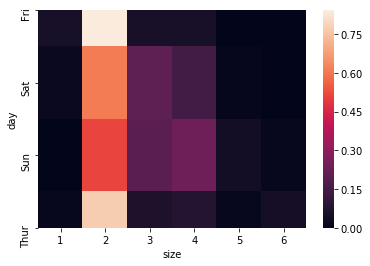

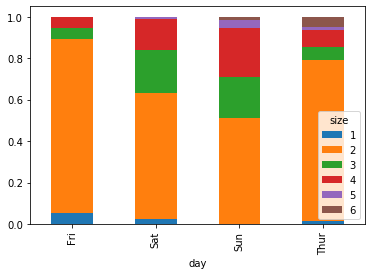

In [61]:
sns.heatmap(counts_given)
counts_given.plot.bar(stacked = True)
#I chose conditional distribution because it shows what portion of the day's customers are what size

**Exercise 2.** Calculate the marginal distribution of day of week in two different ways using the results from the last cell.

In [79]:
joint = day_counts / day_counts.sum().sum()
joint
joint_counts = tips.groupby("day")["smoker"].count()
joint_counts / joint_counts.sum()

day
Fri     0.077869
Sat     0.356557
Sun     0.311475
Thur    0.254098
Name: smoker, dtype: float64

**Exercise 3.** Make a visualization and display the DataFrame that displays the conditional distribution of party size, given the day of the week.  That is, show $P(\text{party size} | \text{day of week})$.

In [91]:
counts_given

size,1,2,3,4,5,6
day,,,,,,
Fri,0.052632,0.842105,0.052632,0.052632,0.000000,0.000000
Sat,0.022989,0.609195,0.206897,0.149425,0.011494,0.000000
Sun,0.000000,0.513158,0.197368,0.236842,0.039474,0.013158
Thur,0.016129,0.774194,0.064516,0.080645,0.016129,0.048387


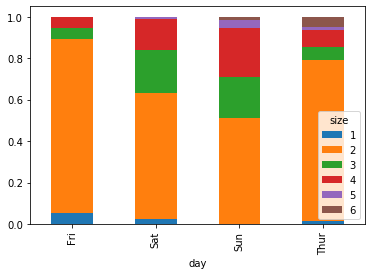

In [84]:
counts_given.plot.bar(stacked = True)

**Exercise 4.** What proportion of Saturday parties had 2 people? Is this the same as the proportion of 2-person parties that dined on Saturday?  Give the equation for both of these and explain the difference

In [121]:
saturday=day_counts.loc["Sat"][2]
sat_val=day_counts.T.sum(axis = 0).loc["Sat"]
saturday/sat_val
# proportion of Saturday parties having 2 people

0.6091954022988506

In [123]:
#find total number of 2 person parties  
two_sum=day_counts.sum(axis = 0)
two_sum.loc[2]
saturday / two_sum.loc[2]
#proportion of 2-person parties that dined on Saturday

0.33974358974358976

**Math Answer Here.**

In [ ]:
#  proportion of Saturday parties had 2 people =  number of two sized parties on saturday/total number of saturday parties
# proportion of 2-person parties that dined on Saturday = number of two sized parties on saturday / total number of two party parties

**Exercise 5.** Report a measure of the strength of the relationship between the size of the party and the day of the week.  Display the count table and the conditional distribution table as well. 

In [129]:
day_counts

size,1,2,3,4,5,6
day,,,,,,
Fri,1.0,16.0,1.0,1.0,0.0,0.0
Sat,2.0,53.0,18.0,13.0,1.0,0.0
Sun,0.0,39.0,15.0,18.0,3.0,1.0
Thur,1.0,48.0,4.0,5.0,1.0,3.0


In [133]:
#get the conditional prob
day = day_counts.sum(axis=1) / N
#get dist of party size
N = day_counts.sum().sum()
#get dist of day distribution
joint = day_counts/ N
adult = day_counts.sum(axis=0) / N
expected = np.outer(day, adult)
#plug them into formula
(joint - expected).abs().sum().sum()

0.25403117441547973

**Bonus Bonus 5 Point Exercise.** We discussed above that the conditional distributions of A given B and the conditional distributions of B given A are _not_ the same. 

Can you figure out a way to relate the two? 

Can you write code that will convert a table with the conditional distributions of A given B, into a table with the conditional distributions of B given A?

To get complete credit you must write code and write the mathmatical formula you use (in math mode offset by \$ symbols) and name the formula correctly.



In [ ]:
# ENTER YOUR CODE HERE